In [1]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as oc
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import micromagneticdata as md
from cycler import cycler
plt.style.use('seaborn-v0_8-white')
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'

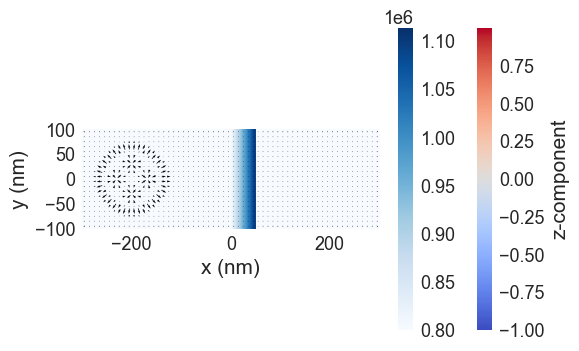

In [82]:
data = md.Data(name='wenzhang1')
fig, ax = plt.subplots(dpi=100)
data[0][-1].orientation.plane(z=5e-10,n=(60,20)).mpl(ax=ax,scalar_kw={'colorbar':True,
                                                        'interpolation':'bilinear','cmap':'coolwarm'},
                                             vector_kw={'colorbar':False,
                                                        'scale':50})
K1.plane(z=25e-10).mpl.scalar(ax=ax,cmap='Blues',alpha=1)
plt.show()

0.005434285909998948
0.011276835010001207
0.0035549053099988015


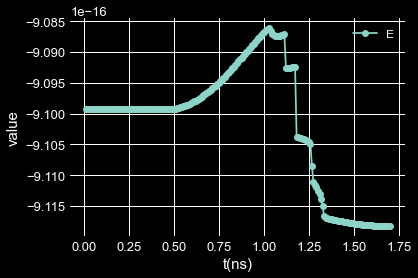

In [15]:
plt.style.use('dark_background')
data = md.Data(name='wenzhang1')
data[5].table.mpl(y=['E'],marker='o')
E = data[5].table.data['E']*1e16
for i in range(1,200):
    if abs(E[i] - E[i-1]) > 0.003:
        print(abs(E[i] - E[i-1]))
    else:
        pass

In [22]:
l = 300e-9
w = 100e-9
region=df.Region(p1=(-l,-w,0),p2=(l,w,3e-9))
subregions={'bottom':df.Region(p1=(-l,-w,0),p2=(l,w,1e-9)),
            'spacer':df.Region(p1=(-l,-w,1e-9),p2=(l,w,2e-9)),
            'top':df.Region(p1=(-l,-w,2e-9),p2=(l,w,3e-9))}
cell=(2e-9,2e-9,1e-9)
mesh=df.Mesh(region=region,cell=cell,subregions=subregions)

In [23]:
Ms={'bottom':0.58e6,'spacer':0,'top':0.58e6}
A={'bottom':15e-12,'spacer':0,'top':15e-12}
D={'bottom':3.5e-3,'spacer':0,'top':3.5e-3}
K={'bottom':0.8e6,'spacer':0,'top':0.8e6}
def K_gai(pos):
    x,y,z=pos
    if 0 <= x <= 50e-9:
        return 0.8e6 + (1.12-0.80)*1e6 * x/50e-9
    else:
        return 0.8e6
def K_fun(pos):
    x,y,z=pos
    if -200e-9 <= x <= -180e-9:
        return 0.8e6 + (1.27-0.80)*1e6 * (x+200e-9)/20e-9
    elif 0 <= x <= 20e-9:
        return 0.8e6 + (1.27-0.80)*1e6 * (x)/20e-9
    elif 200e-9 <= x <= 220e-9 and -10e-9 <= y <= 100e-9:
        return 0.8e6 + (1.27-0.80)*1e6 * (x-200e-9)/20e-9
    else:
        return 0.8e6
K1=df.Field(mesh,dim=1,value=K_gai)

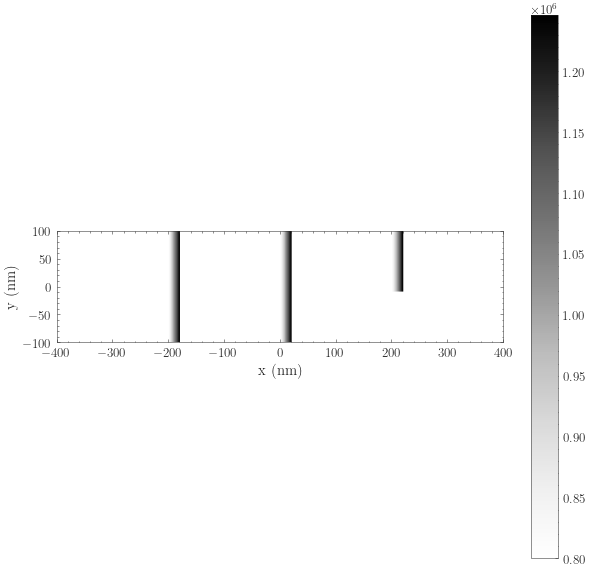

In [99]:
K.plane(z=0).mpl.scalar(figsize=(10,10))

In [5]:
def m_init(pos):
    x,y,z=pos
    if 0 <= z < 1e-9:
        if ((x+120e-9)**2+y**2)**0.5 <= 8e-9:
            return (0,0,-1)
        elif ((x+80e-9)**2+y**2)**0.5 <= 8e-9:
            return (0,0,-1)
        elif ((x+100e-9)**2+(y-20e-9)**2)**0.5 <= 8e-9:
            return (0,0,-1)
        elif ((x+100e-9)**2+(y+20e-9)**2)**0.5 <= 8e-9:
            return (0,0,-1)
        elif ((x+100e-9)**2+y**2)**0.5 <= 70e-9:
            return (0,0,1)
        else :
            return (0,0,-1)
    else:
        if ((x+120e-9)**2+y**2)**0.5 <= 8e-9:
            return (0,0,1)
        elif ((x+80e-9)**2+y**2)**0.5 <= 8e-9:
            return (0,0,1)
        elif ((x+100e-9)**2+(y-20e-9)**2)**0.5 <= 8e-9:
            return (0,0,1)
        elif ((x+100e-9)**2+(y+20e-9)**2)**0.5 <= 8e-9:
            return (0,0,1)
        elif ((x+100e-9)**2+y**2)**0.5 <= 70e-9:
            return (0,0,-1)
        else :
            return (0,0,1)

In [6]:
system = mm.System(name='wenzhang1')
system.energy = mm.Exchange(A=A)+mm.UniaxialAnisotropy(K=K1,u=(0,0,1))\
             +mm.Demag()+mm.DMI(D=D,crystalclass='Cnv_z')\
             +mm.RKKY(sigma=-2e-3,sigma2=0,subregions=['bottom','top'])
system.dynamics = mm.Precession(gamma0=2.211e5)+mm.Damping(alpha=0.3)
system.m = df.Field(mesh,dim=3,value=m_init,norm=Ms)
oc.runner.runner = oc.oommf.DockerOOMMFRunner()

Running OOMMF (DockerOOMMFRunner)[2022/04/29 10:28]... (7.4 s)
OOMMF found and running.


In [7]:
td=oc.TimeDriver()
td.drive(system,t=0.2e-9,n=10)

Running OOMMF (DockerOOMMFRunner)[2022/04/29 10:28]... (200.2 s)


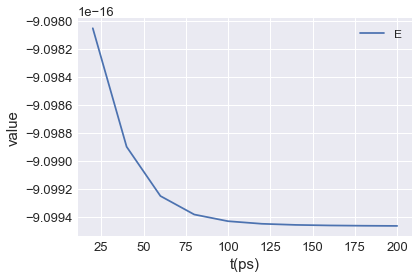

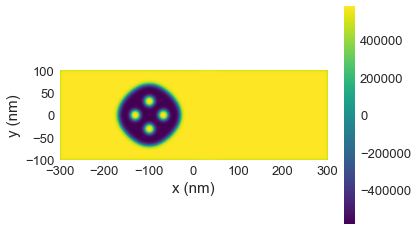

In [8]:
system.table.mpl(y=['E'])
system.m.plane(z=3e-9).z.mpl.scalar()

In [9]:
system.dynamics += mm.ZhangLi(u=200,beta=0.4)
td.drive(system,t=1.5e-9,n=80)

Running OOMMF (DockerOOMMFRunner)[2022/04/29 10:40]... (1454.8 s)


In [32]:
data = md.Data(name='wenzhang1')
X = []
Y = []
for i in range(0,181):
    m = data[-1][i].orientation.plane(z=0)
    q = m @ (m.derivative('x') & m.derivative('y'))
    Q = df.integral(q * df.dx * df.dy) / (4 * np.pi)
    x = df.Field(data[-1][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[0])
    y = df.Field(data[-1][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[1])
    Rx = df.integral(x * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    Ry = df.integral(y * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    X.append(Rx)
    Y.append(Ry)

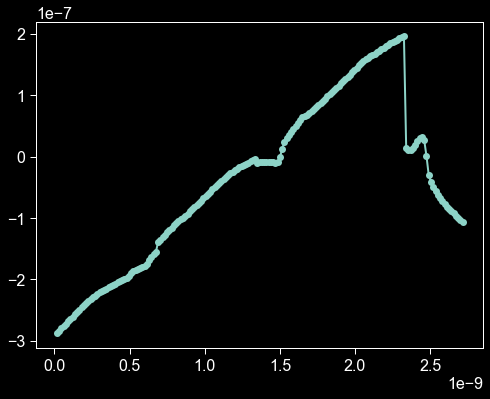

In [46]:
t = data[-1].table.data['t'][:-3]
with plt.style.context(['notebook','dark_background']):
    plt.plot(t,X,marker='o')

In [ ]:
data = md.Data(name='wenzhang1')
plt.style.use('seaborn-white')
fig, ax = plt.subplots(dpi=100)
data[1][0].plane(z=0).z.k3d.scalar()
plt.show()

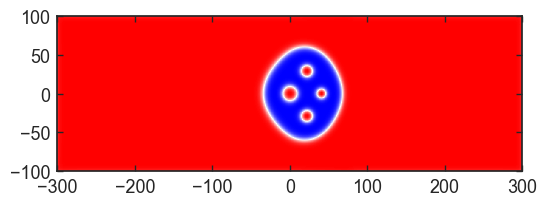

In [13]:
data = md.Data(name='skg2')
with plt.style.context(['seaborn-white']):
    fig, ax = plt.subplots(dpi=100)
    data[115][120].plane(z=3e-9).z.mpl.scalar(ax=ax,cmap='bwr',colorbar=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(which='major',length=4,labelsize=13,direction='in')
    plt.savefig('f:/tupian/s3_3.png',dpi=600,bbox_inches='tight')
    plt.show()

C:\Users\86293\AppData\Local\Temp/ipykernel_11596/784807881.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','S(4)','S(3)','S(2)'])


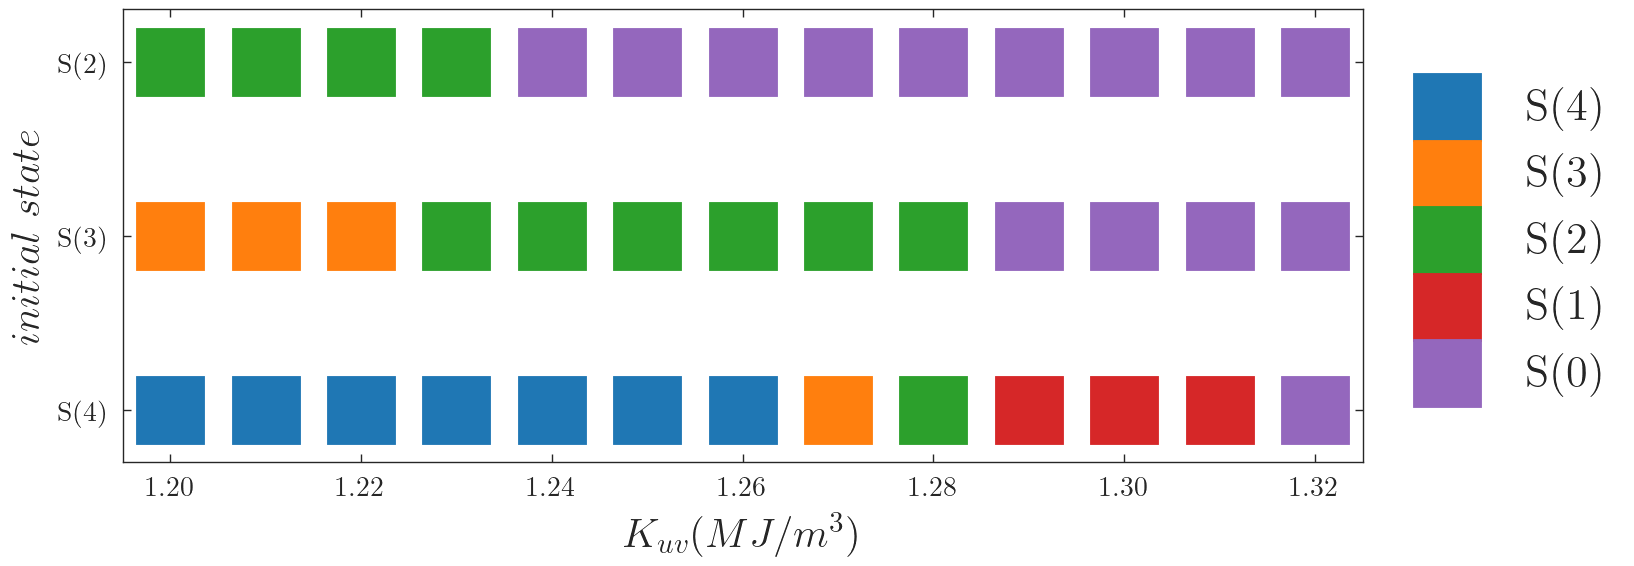

In [73]:
plt.style.use(['seaborn-white','science'])
fig = plt.figure(figsize=(8,3),dpi=200)
ax = fig.add_subplot(111)
s4 = plt.scatter(np.arange(1.20,1.26,0.01),[1]*7,marker='s',color='tab:blue',s=600,label='S(4)')
s3 = plt.scatter([1.20,1.21,1.22,1.27],[2,2,2,1],marker='s',color='tab:orange',s=600,label='S(3)')
s2 = plt.scatter(np.arange(1.20,1.23,0.01),[3]*4,marker='s',color='tab:green',s=600,label = 'S(2)')
plt.scatter(np.arange(1.23,1.28,0.01),[2]*6,marker='s',color='tab:green',s=600)
plt.scatter([1.28],[1],marker='s',color='tab:green',s=600)
s1 = plt.scatter([1.29,1.30,1.31],[1]*3,marker='s',color='tab:red',s=600,label='S(1)')
s0 = plt.scatter([1.32],[1],marker='s',color='tab:purple',s=600,label = 'S(0)')
plt.scatter(np.arange(1.29,1.32,0.01),[2]*4,marker='s',color='tab:purple',s=600)
plt.scatter(np.arange(1.24,1.32,0.01),[3]*9,marker='s',color='tab:purple',s=600)
plt.ylabel(r'$initial\ state$',fontsize=15)
plt.xlabel(r'$K_{uv}(MJ/m^{3})$',fontsize=15)
y_major_locator = plt.MultipleLocator(1)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_yticklabels(['','S(4)','S(3)','S(2)'])
ax.tick_params(labelsize=10)
ax.tick_params(which='minor',length=0)
ax.set_xlim(1.195,1.325)
ax.set_ylim(0.7,3.3)
plt.legend(bbox_to_anchor=(1,0.92),fontsize=16)
ax = plt.gca()
plt.savefig('f:/tupian/xiangtu')
plt.show()

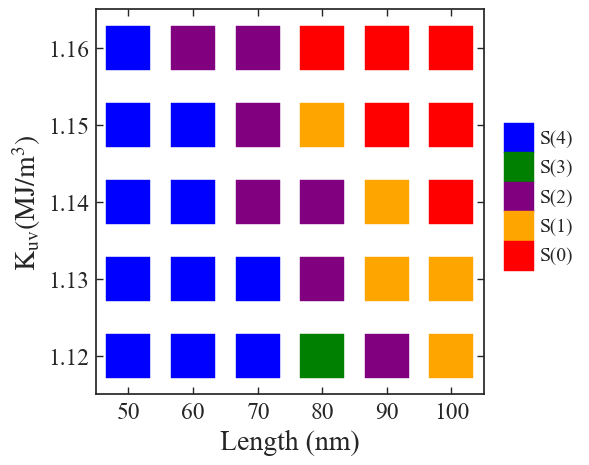

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
size = 1000
s4=plt.scatter([50]*5,np.arange(1.12,1.17,0.01),marker='s',color='b',s=size)
plt.scatter([60]*4,np.arange(1.12,1.16,0.01),marker='s',color='b',s=size)
plt.scatter([70]*2,[1.12,1.13],marker='s',color='b',s=size)
s3=plt.scatter([80],[1.12],marker='s',color='g',s=size)
s2=plt.scatter([80]*2,[1.13,1.14],marker='s',color='purple',s=size)
plt.scatter([60],[1.16],marker='s',color='purple',s=size)
plt.scatter([70]*3,[1.15,1.14,1.16],marker='s',color='purple',s=size)
plt.scatter([90],[1.12],marker='s',color='purple',s=size)
s1=plt.scatter([80],[1.15],marker='s',color='orange',s=size)
plt.scatter([90]*2,[1.13,1.14],marker='s',color='orange',s=size)
plt.scatter([100]*2,[1.12,1.13],marker='s',color='orange',s=size)
s0=plt.scatter([80],[1.16],marker='s',color='r',s=size)
plt.scatter([90]*2,[1.15,1.16],marker='s',color='r',s=size)
plt.scatter([100]*3,[1.14,1.15,1.16],marker='s',color='r',s=size)
plt.xticks(np.arange(50,110,10))
plt.yticks(np.arange(1.12,1.17,0.01))
plt.xlabel('Length (nm)',fontsize=20)
plt.ylabel(r'$\mathrm{K_{uv}(MJ/m^{3})}$',fontsize=20)
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='minor',length=0)
ax.tick_params(which='major',length=5,labelsize=17,direction='in')
ax.set_xlim(45,105)
ax.set_ylim(1.115,1.165)
ax = plt.gca()
plt.legend([s4,s3,s2,s1,s0],['S(4)','S(3)','S(2)','S(1)','S(0)'],
           fontsize=14,bbox_to_anchor=(1,0.73),markerscale=0.7,
           borderpad=0.3,handletextpad=0.1,labelspacing=0.58)
plt.savefig('f:/tupian/scatter1.png',dpi=600,bbox_inches='tight')
plt.show()

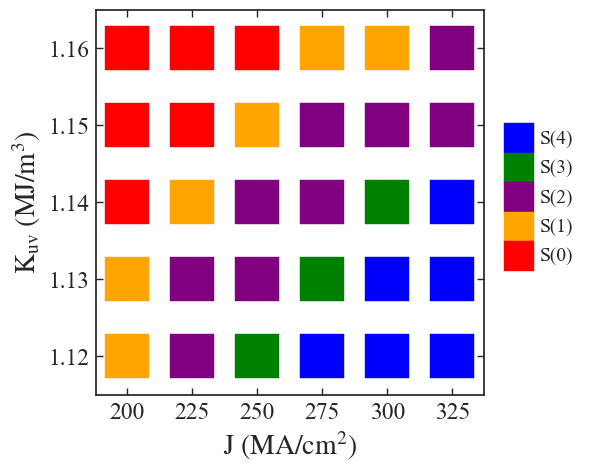

In [6]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
size = 1000
s4=plt.scatter([325]*3,np.arange(1.12,1.15,0.01),marker='s',color='b',s=size,label='S(4)')
plt.scatter([300]*2,np.arange(1.12,1.14,0.01),marker='s',color='b',s=size)
plt.scatter([275],[1.12],marker='s',color='b',s=size)
s3=plt.scatter([250,275,300],[1.12,1.13,1.14],marker='s',color='g',s=size,label='S(3)')
s2=plt.scatter([275,300,325],[1.15]*3,marker='s',color='purple',s=size,label = 'S(2)')
plt.scatter([325,275],[1.16,1.14,],marker='s',color='purple',s=size)
plt.scatter([225]*2,[1.12,1.13],marker='s',color='purple',s=size)
plt.scatter([250]*2,[1.13,1.14],marker='s',color='purple',s=size)
s1=plt.scatter([200]*2,[1.12,1.13],marker='s',color='orange',s=size,label='S(1)')
plt.scatter([225,250],[1.14,1.15],marker='s',color='orange',s=size)
plt.scatter([275,300],[1.16]*2,marker='s',color='orange',s=size)
s0=plt.scatter([200]*3,[1.14,1.15,1.16],marker='s',color='r',s=size,label = 'S(0)')
plt.scatter([225]*2,[1.15,1.16],marker='s',color='r',s=size)
plt.scatter([250],[1.16],marker='s',color='r',s=size)
plt.xticks(np.arange(200,350,25))
plt.yticks(np.arange(1.12,1.17,0.01))
plt.xlabel(r'$\mathrm{J\ (MA/{cm}^{2})}$',fontsize=20)
plt.ylabel(r'$\mathrm{K_{uv}\ (MJ/m^{3})}$',fontsize=20)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(20))
ax.tick_params(which='major',length=5,labelsize=17,direction='in')
ax.tick_params(which='minor',length=0)
ax.set_xlim(188,337)
ax.set_ylim(1.115,1.165)
plt.legend(bbox_to_anchor=(1,0.73),fontsize=14,markerscale=0.7,
           borderpad=0.3,handletextpad=0.1,labelspacing=0.58)
plt.savefig('f:/tupian/scatter2.png',dpi=600,bbox_inches='tight')
plt.show()

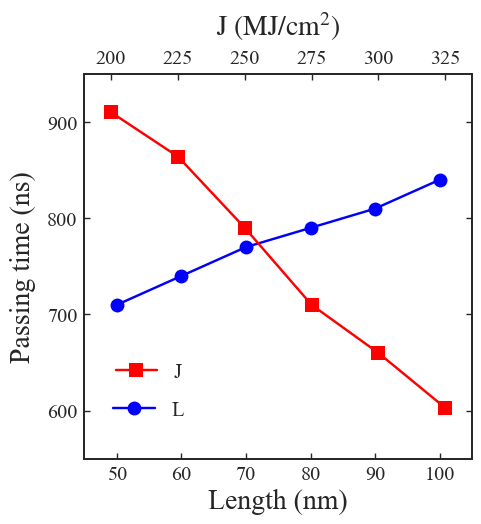

In [8]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot()
ax2 = ax1.twiny()
ax1.plot(range(50,110,10),[710,740,770,790,810,840],c='b',label='L',marker='o',markersize=10)
ax2.plot(range(200,350,25),[910,864,790,710,660,603],c='r',label='J',marker='s',markersize=10)
ax1.set(xlim=(45,105))
ax2.set(xlim=(190,335),ylim=(550,950))
ax1.xaxis.set_major_locator(plt.MultipleLocator(10))
ax2.xaxis.set_major_locator(plt.MultipleLocator(25))
ax2.yaxis.set_major_locator(plt.MultipleLocator(100))
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(which='minor',length=0)
ax2.tick_params(which='minor',length=0)
ax1.tick_params(which='major',length=4,direction='in',labelsize=14.5)
ax2.tick_params(which='major',length=4,direction='in',labelsize=14.5)
ax1.set_xlabel('Length (nm)',fontsize=20,labelpad=3)
ax1.set_ylabel('Passing time (ns)',fontsize=20,labelpad=8)
ax2.set_xlabel(r'$\mathrm{J\ (MJ/{cm}^2)}$',fontsize=20,labelpad=10)
ax1.legend(bbox_to_anchor=(0.305,0.2),fontsize=15)
ax2.legend(bbox_to_anchor=(0.3,0.3),fontsize=15)
plt.savefig('f:/tupian/shuangqu.png',dpi=600,bbox_inches='tight')
plt.show()

In [225]:
#计算J和U的换算
a = 2 * mm.consts.e * 0.58e6 / (0.5 * mm.consts.muB * mm.consts.g)
print(a)
list(map(lambda x: x*a*1e-10, range(160,280,20)))

9996872352.25655


[159.94995763610478,
 179.9437023406179,
 199.93744704513102,
 219.9311917496441,
 239.92493645415718,
 259.9186811586703]

In [9]:
data1 = md.Data(name='skg2')
data2 = md.Data(name='wenzhang1')

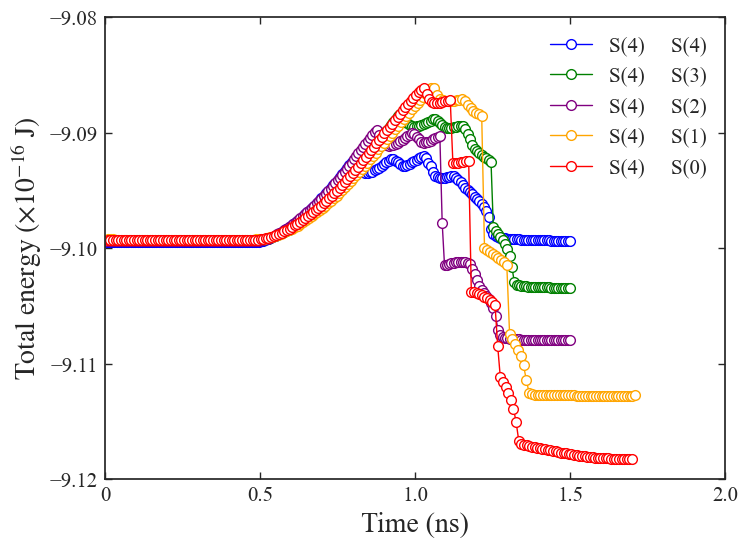

In [12]:
E3 = data1[115].table.data['E'] * 1e16
E2 = data2[1].table.data['E'] * 1e16
E1 = data2[3].table.data['E'][:190] * 1e16
E0 = data2[5].table.data['E'] * 1e16
E4 = data2[7].table.data['E'] * 1e16
t3 = data1[115].table.data['t'] * 1e9
t2 = data2[1].table.data['t'] * 1e9
t1 = data2[3].table.data['t'][:190] * 1e9
t0 = data2[5].table.data['t'] * 1e9
t4 = data2[7].table.data['t'] * 1e9
fig,ax = plt.subplots(figsize=(8,6))
lw = 1
size = 7
ew = 1
ax.plot(t4,E4,color='b',marker='o',lw=lw,markersize=size,markerfacecolor='w',
         markeredgecolor='b',markeredgewidth=ew,label='S(4)     S(4)')
ax.plot(t3,E3,color='g',marker='o',lw=lw,markersize=size,markerfacecolor='w',
         markeredgecolor='g',markeredgewidth=ew,label='S(4)     S(3)')
ax.plot(t2,E2,color='purple',marker='o',lw=lw,markersize=size,markerfacecolor='w',
         markeredgecolor='purple',markeredgewidth=ew,label='S(4)     S(2)')
ax.plot(t1,E1,color='orange',marker='o',lw=lw,markersize=size,markerfacecolor='w',
         markeredgecolor='orange',markeredgewidth=ew,label='S(4)     S(1)')
ax.plot(t0,E0,color='r',marker='o',lw=lw,markersize=size,markerfacecolor='w',
         markeredgecolor='r',markeredgewidth=ew,label='S(4)     S(0)')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_major_locator(plt.FixedLocator([0,0.5,1,1.5,2]))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.tick_params(which='minor',length=0)
ax.tick_params(which='major',length=5,direction='in',labelsize=15)
ax.set_xticklabels(['0','0.5','1.0','1.5','2.0'])
plt.xlim(0,2)
plt.ylim(-9.12,-9.08)
plt.xlabel('Time (ns)',fontsize=20)
plt.ylabel(r'$\mathrm{Total\ energy\ (\times10^{-16}\ J)}$',fontsize=20)
plt.legend(loc='best',fontsize=15,handlelength=2)
plt.savefig('f:/tupian/duo_neng.png',dpi=600,bbox_inches='tight')
plt.show()

In [20]:
a0 = E0[199]
a1 = E1[189]
a2 = E2[199]
a3 = E3[199]
a4 = E4[199]
print(a4-a3,a3-a2,a2-a1,a1-a0)

0.004074316429999669 0.004501550300000545 0.00480432336000014 0.005490981220001245


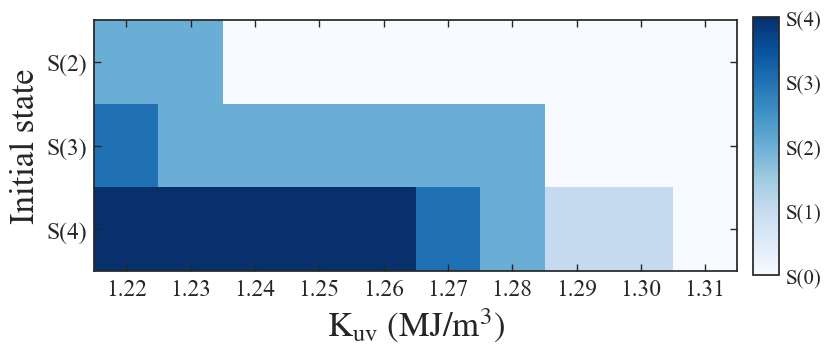

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
x = list(np.arange(1.22,1.31,0.01))
x[-2] = '1.30'
y = np.arange(2,5,1)
Z = np.array([[2,2,0,0,0,0,0,0,0,0],
            [3,2,2,2,2,2,2,0,0,0],
            [4,4,4,4,4,3,2,1,1,0]]) 
plt.imshow(Z,cmap='Blues',interpolation='none')
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
plt.yticks([2,1,0],labels=['S(4)','S(3)','S(2)'],fontsize=20)
plt.xticks(range(10),labels=x,fontsize=20)
plt.xlabel(r'$\mathrm{K_{uv}\ (MJ/{m}^3})$',fontsize=25)
plt.ylabel('Initial state',fontsize=25)
cbar = plt.colorbar(shrink=0.67,aspect=10,pad=0.02)
cbar.set_ticks(range(0,5),labels=['S(0)','S(1)','S(2)','S(3)','S(4)'])
cbar.ax.tick_params(labelsize=15)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params(which='minor',length=0)
ax.tick_params(which='major',length=5,direction='in',labelsize=17)
ax.set_aspect(1.3)
plt.savefig('f:/tupian/imshow.png',dpi=600,bbox_inches='tight')
plt.show()

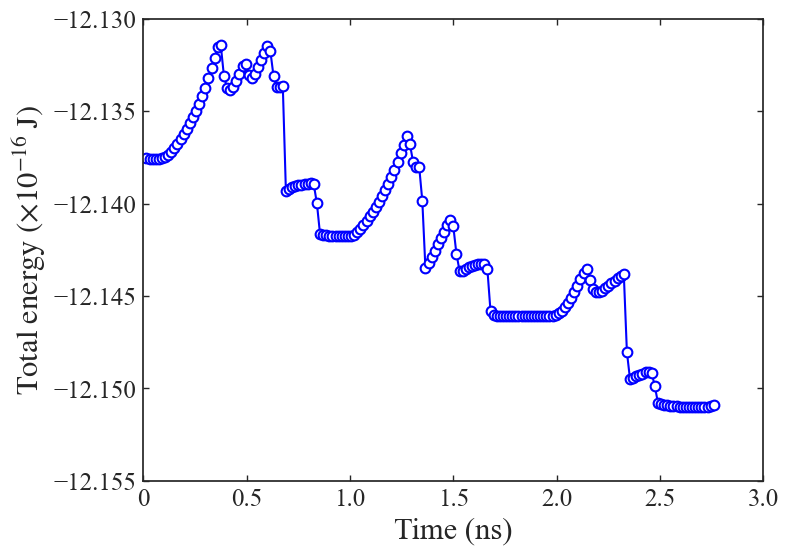

In [18]:
data = md.Data(name='wenzhang1')
E = data[11].table.data['E']*1e16
t = data[11].table.data['t']*1e9
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(t,E,color='b',marker='o',lw=1.5,markersize=7,markerfacecolor='w',\
            markeredgecolor='b',markeredgewidth=1.5)
ax.set(xlim=(0,3),ylim=(-12.155,-12.130))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.005))
ax.xaxis.set_major_locator(plt.FixedLocator([0,0.5,1.0,1.5,2.0,2.5,3.0]))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xticklabels(['0','0.5','1.0','1.5','2.0','2.5','3.0'])
ax.tick_params(which='major',length=4,direction='in',labelsize=18)
plt.xlabel('Time (ns)',fontsize=22)
plt.ylabel(r'$\mathrm{Total\ energy\ (\times10^{-16}\ J)}$',fontsize=22)
plt.savefig('f:/tupian/dan_neng.png',dpi=600,bbox_inches='tight')
plt.show()

In [24]:
e0 = data2[-1].table.data['E'][0]*1e19
e1 = data2[-1].table.data['E'][60]*1e19
e2 = data2[-1].table.data['E'][120]*1e19
e3 = data2[-1].table.data['E'][180]*1e19
print(e0-e1,e1-e2,e2-e3)
e0,e1,e2,e3

4.191459100000429 4.354341800000839 4.921861500000887


(-12137.549600699998, -12141.741059799999, -12146.0954016, -12151.0172631)

C:\Users\86293\AppData\Local\Temp\ipykernel_12860\2471269692.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(-400,500,100),fontsize=15)
C:\Users\86293\AppData\Local\Temp\ipykernel_12860\2471269692.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-200,-100,0,100],fontsize=15)


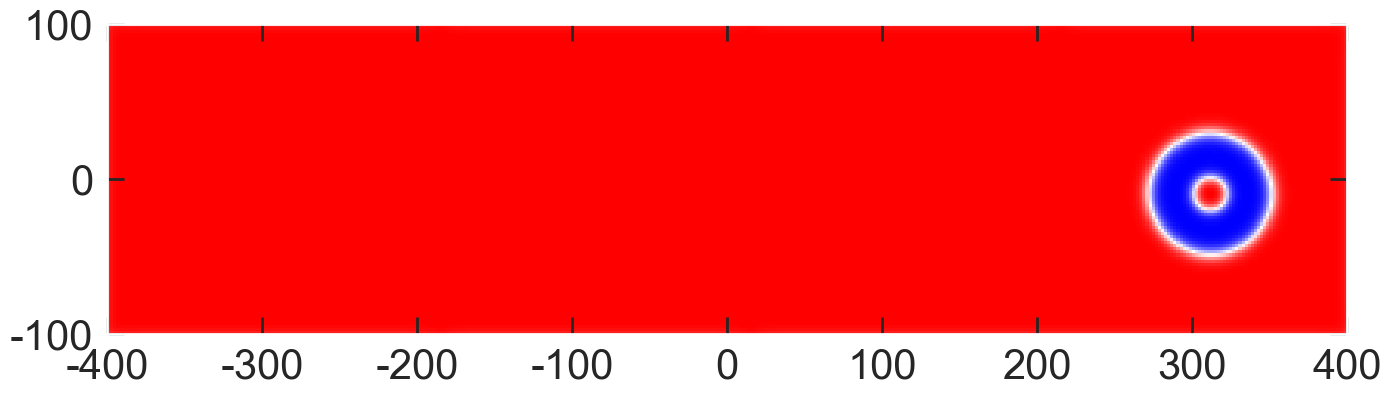

In [45]:
data = md.Data(name='wenzhang1')
with plt.style.context(['science','notebook']):
    fig, ax = plt.subplots(dpi=200)
    data[11][175].z.plane(z=3e-9).mpl.scalar(ax=ax,figsize=(10,10),cmap='bwr',colorbar=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    x_minor_locator = plt.MultipleLocator(50)
    y_minor_locator = plt.MultipleLocator(50)
    y_major_locator = plt.MultipleLocator(100)
    ax.xaxis.set_minor_locator(x_minor_locator)
    ax.yaxis.set_minor_locator(y_minor_locator)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.set_xticklabels(range(-400,500,100),fontsize=15)
    ax.set_yticklabels([-200,-100,0,100],fontsize=15)
    plt.tick_params(axis='both',length=0,which='minor')
    plt.savefig('f:/tupian/last6.png')
    plt.show()

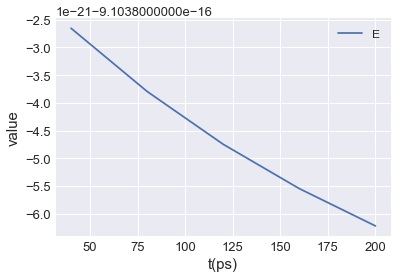

In [10]:
system.table.mpl(y=['E'])